In [1]:
import requests
import matplotlib.colors as colors
import matplotlib.cm as cm
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)

In [2]:
# configure the place, network type, trip times, and travel speed
place = 'Boston, MA, USA'
network_type = 'walk'
trip_times = [5, 10, 15] #in minutes

travel_speed = 4 #walking speed in km/hour

In [3]:
G = ox.graph_from_place(place, network_type=network_type)

In [4]:

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [5]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Travel time by foot

In [6]:
# get one color for each isochrone
# change cmap to "Reds" if buggy
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

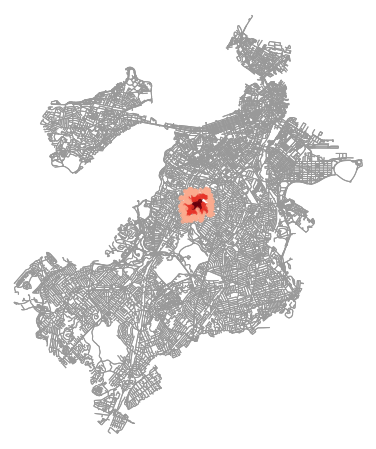

In [7]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
                                            
    
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [8]:
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

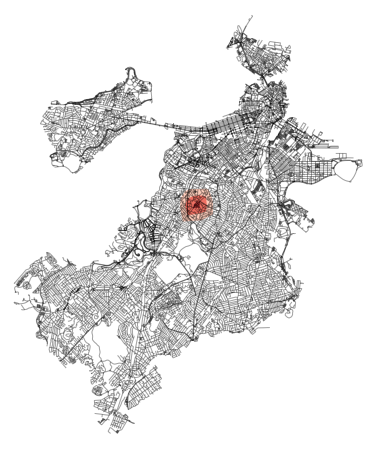

In [9]:
# plot the network then add isochrones as colored descartes polygon patches

fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [1]:
#ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
#ox.save_graphml(G, filename='mynetwork.graphml')